In [37]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [39]:
file_name_all = '/content/gdrive/MyDrive/대학원/연도별/2021년 하/XAI608 Application DL/proposed_project/heloc_dataset_v1.csv'

In [40]:
data_pd_all = pd.read_csv(file_name_all)

In [41]:
data_pd_all['RiskPerformance'].value_counts()

Bad     5459
Good    5000
Name: RiskPerformance, dtype: int64

In [42]:
feature_columns = list(data_pd_all.columns.difference(['RiskPerformance']))

In [43]:
data_pd_all['truth_val'] = np.where(data_pd_all['RiskPerformance']=='Good', 1, 0)
data_pd_all = data_pd_all.drop(['RiskPerformance'], axis=1)

In [44]:
def list_avg(lst):
    return sum(lst) / len(lst)

# ROC Curve function
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

def display_scores(y_test, y_pred):
    '''
    Display ROC-AUC score, f1 score and classification report of a model.
    '''
    print(f"F1 Score: {round(f1_score(y_test, y_pred)*100,2)}%") 
    print(f"Classification Report: \n {classification_report(y_test, y_pred)}")

In [45]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import ShuffleSplit,train_test_split, cross_val_score, GridSearchCV, learning_curve

from sklearn.metrics import f1_score, classification_report, mean_squared_error, recall_score, precision_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier

In [46]:
# 데이터들이 때략 다들 정규분포를 따르고 있고 아웃라이어도 엄청 크지 않으며
# 데이터 설명을 볼 경우 큰 특이점이 없기에 MinMax 스케일러 사용함
scaled_data_pd = data_pd_all.copy()
scaler = MinMaxScaler()

In [47]:
feature_columns = list(scaled_data_pd.columns.difference(['truth_val']))

y_all = scaled_data_pd['truth_val'].squeeze()
x_all = scaled_data_pd[feature_columns].squeeze()
y_all = pd.to_numeric(y_all)
x_all = scaler.fit_transform(x_all)

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x_all,y_all,test_size=0.3, random_state=604)

In [49]:
model_rfc = RandomForestClassifier(n_estimators=10)

In [50]:
model_rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [51]:
import pickle
filename = '/content/gdrive/MyDrive/대학원/연도별/2021년 하/XAI608 Application DL/proposed_project/rf_base_model.sav'
pickle.dump(model_rfc, open(filename, 'wb'))

In [52]:
model_rfc.score(x_test, y_test)

0.6896112173358827

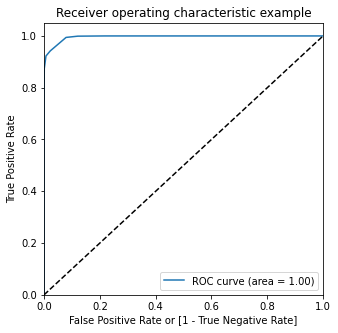

In [53]:
y_train_prect_rfc = model_rfc.predict_proba(x_train)[:,1]
draw_roc(y_train.to_numpy(), y_train_prect_rfc)

In [54]:
y_test_prect_rfc = model_rfc.predict(x_test)
display_scores(y_test, y_test_prect_rfc)

F1 Score: 63.95%
Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.79      0.73      1638
           1       0.72      0.58      0.64      1500

    accuracy                           0.69      3138
   macro avg       0.70      0.68      0.68      3138
weighted avg       0.69      0.69      0.69      3138



In [55]:
find_proba_cls = model_rfc.predict(x_all)
find_proba_rfc = model_rfc.predict_proba(x_all)[:,1]

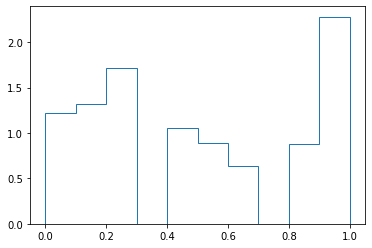

In [56]:
# 양쪽 끝
plt.hist(find_proba_rfc, bins=10, density=True, histtype='step')
plt.show()

In [57]:
rfc_dataset = scaled_data_pd.copy()
rfc_dataset['predict_c'] = find_proba_cls
rfc_dataset['predict_v'] = find_proba_rfc

In [58]:
# 등급 컨디션
condtions_1 = [(rfc_dataset['predict_v'] >= 0.8),
               (rfc_dataset['predict_v'] < 0.8) & (rfc_dataset['predict_v'] >= 0.6),
               (rfc_dataset['predict_v'] < 0.6) & (rfc_dataset['predict_v'] >= 0.4),
               (rfc_dataset['predict_v'] < 0.4) & (rfc_dataset['predict_v'] >= 0.2),
               (rfc_dataset['predict_v'] < 0.2)]
choices_1 = [1,2,3,4,5]

In [59]:
def ranking_5_pandas(pd_master, predict_label, predict_c, truth_label, ranking_list) :
    ranking_list.sort()
    choices = [1,2,3,4,5]
    condtions = [(rfc_dataset[predict_label] >= ranking_list[3]),
                 (rfc_dataset[predict_label] < ranking_list[3]) & (rfc_dataset[predict_label] >= ranking_list[2]),
                 (rfc_dataset[predict_label] < ranking_list[2]) & (rfc_dataset[predict_label] >= ranking_list[1]),
                 (rfc_dataset[predict_label] < ranking_list[1]) & (rfc_dataset[predict_label] >= ranking_list[0]),
                 (rfc_dataset[predict_label] < ranking_list[0])]
    
    pd_master['rank'] = np.select(condtions, choices, default='5')
    
    #pd_master['acc_v'] = np.where(pd_master[predict_c] == pd_master[truth_label], '1', '0')
    
    pd_master.loc[pd_master[truth_label] == pd_master[predict_c], 'acc_v'] = '1'
    pd_master.loc[pd_master[truth_label] != pd_master[predict_c], 'acc_v'] = '0'
    
    truth_ch = [1,2,3,4]
    truth_con = [ (pd_master[truth_label] == 1) & (pd_master[predict_c] == 1), # truth Postive
                  (pd_master[truth_label] == 1) & (pd_master[predict_c] == 0), # false negative
                  (pd_master[truth_label] == 0) & (pd_master[predict_c] == 1), # false postive
                  (pd_master[truth_label] == 0) & (pd_master[predict_c] == 0) # true negative
                ]
    pd_master['f_p_t'] = np.select(truth_con, truth_ch)
    
    for each_class in choices :
        print("Class : ", each_class)
        temp_df = pd_master[(pd_master["rank"] == str(each_class))]
        t1 = temp_df[truth_label].tolist()
        t2 = temp_df[predict_c].tolist()
        
        t_ac = accuracy_score(t1, t2)
        t_pr = recall_score(t1, t2)
        t_rc = precision_score(t1, t2)
        t_f1 = f1_score(t1, t2)
        
        print('Acuuracy  : ', t_ac)
    
    return pd_master

In [60]:
importances = model_rfc.feature_importances_
forest_importances = pd.Series(importances, index=feature_columns)

In [61]:
std = np.std([
    tree.feature_importances_ for tree in model_rfc.estimators_], axis=0)

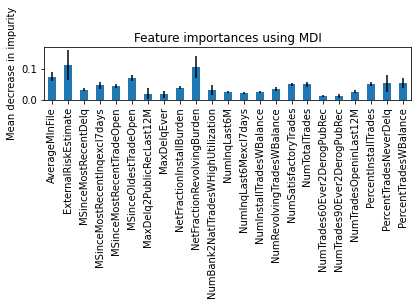

In [62]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [63]:
r_list = [0.2, 0.4, 0.6, 0.8]
rfc_dataset = ranking_5_pandas(rfc_dataset, 'predict_v', 'predict_c', 'truth_val', r_list)

Class :  1
Acuuracy  :  0.962224236929586
Class :  2
Acuuracy  :  0.7918118466898955
Class :  3
Acuuracy  :  0.5779345734445157
Class :  4
Acuuracy  :  0.8963210702341137
Class :  5
Acuuracy  :  0.9762174405436014


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
